**Homework 9:**



# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import pandas as pd
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ensembles"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [4]:
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem

from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit import DataStructs
from rdkit.DataStructs import ConvertToNumpyArray

from rdkit.Chem import PandasTools

# Load the data

In [5]:
#
datapath = os.path.join("data/raw", "esol.csv")
esol_data = pd.read_csv(datapath)
esol_data.head()

,cano_smiles,activity,group
0,Cc1occc1C(=O)Nc1ccccc1,-3.30,train
1,CC(C)=CCCC(C)=CC=O,-2.06,train
2,c1ccc2c(c1)ccc1c2ccc2c3ccccc3ccc21,-7.87,train
3,c1ccsc1,-1.33,train
4,c1ccc2scnc2c1,-1.50,train


## Data preprocessing

In [6]:
esol_data.describe()

,activity
count,1127.000000
mean,-3.052010
std,2.096392
min,-11.600000
25%,-4.321000
50%,-2.860000
75%,-1.600000
max,1.580000


In [7]:
#Generate data exploration
esol_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1127 entries, 0 to 1126
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   cano_smiles  1127 non-null   object 
 1   activity     1127 non-null   float64
 2   group        1127 non-null   object 
dtypes: float64(1), object(2)
memory usage: 26.5+ KB


## Molecule genaration

In [8]:
# Create Mol rdkit objects for each smile
PandasTools.AddMoleculeColumnToFrame(frame=esol_data, smilesCol='cano_smiles', molCol='Molecule')

In [9]:
# Create Mol rdkit objects for each smile (option)
#bbbp_data["Mol"] = [Chem.MolFromSmiles(x) for x in bbbp_data["cano_smiles"]]

There are a couple of SMILES that could be parsed by RDKit. For wrong SMILES, rdkit would return 'None'.

In [10]:
#sum(esol_data['Molecule'].map(lambda x: x is None))

,cano_smiles,activity,group,Molecule
0,Cc1occc1C(=O)Nc1ccccc1,-3.3,train,

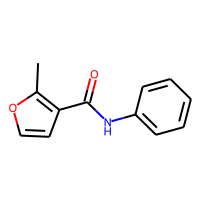

In [11]:
esol_data.head(1)

In [12]:
#Generate data exploration
esol_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1127 entries, 0 to 1126
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   cano_smiles  1127 non-null   object 
 1   activity     1127 non-null   float64
 2   group        1127 non-null   object 
 3   Molecule     1127 non-null   object 
dtypes: float64(1), object(3)
memory usage: 35.3+ KB


### Morgan Fingerprint generation
A fingerprint is generated for each compound in the "Molecule" column with a radius of 2 and a bit length of 2048.

In [13]:
#create a column for Morgan fingerprints
n_Bits = 2048
esol_data["MorgFP"] = [AllChem.GetMorganFingerprintAsBitVect(m, 2, nBits = n_Bits, useFeatures=True) for m in esol_data['Molecule']]## Molecule genaration

In [14]:
esol_data["MorgFP"].head()

0    [1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...
1    [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2    [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
3    [0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...
4    [0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: MorgFP, dtype: object

In [15]:
type(esol_data["MorgFP"])

pandas.core.series.Series

In [16]:
esol_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1127 entries, 0 to 1126
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   cano_smiles  1127 non-null   object 
 1   activity     1127 non-null   float64
 2   group        1127 non-null   object 
 3   Molecule     1127 non-null   object 
 4   MorgFP       1127 non-null   object 
dtypes: float64(1), object(4)
memory usage: 44.1+ KB


### Splitting and Visualizing the data

In [17]:
#Finds Null data in any row if any
sample_incomplete_rows = esol_data[esol_data.isnull().any(axis=1)]
sample_incomplete_rows.head(len(sample_incomplete_rows))

,cano_smiles,activity,group,Molecule,MorgFP


In [18]:
#Returns number of unique values in the specifed column to make sure that no duplications there
esol_data['cano_smiles'].nunique()

1116

In [19]:
#Returns number of total rows
esol_data['cano_smiles'].count()

1127

In [20]:
#Drops the duplicated ones
esol_data = esol_data.drop_duplicates(['cano_smiles'])

In [21]:
esol_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1116 entries, 0 to 1126
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   cano_smiles  1116 non-null   object 
 1   activity     1116 non-null   float64
 2   group        1116 non-null   object 
 3   Molecule     1116 non-null   object 
 4   MorgFP       1116 non-null   object 
dtypes: float64(1), object(4)
memory usage: 52.3+ KB


In [22]:
#Returns the training set
train = esol_data[esol_data["group"]=="train"]
len(train)

893

In [23]:
#Returns the test set
test = esol_data[esol_data["group"]=="test"]
len(test)

112

In [24]:
#Returns the valid set
valid = esol_data[esol_data["group"]=="valid"]
len(valid)

111

In [25]:
# Specifing the columns for dependent and independent variables (Training dataset)
X_train = train["MorgFP"].values
y_train = train["activity"].values

In [26]:
# Specifing the columns for dependent and independent variables (Test dataset)
X_test = test["MorgFP"].values
y_test = test["activity"].values

In [27]:
# Specifing the columns for dependent and independent variables (Validation dataset)
X_valid = valid["MorgFP"].values
y_valid = valid["activity"].values

**Convert the RDKit explicit vectors into numpy arrays**

In [28]:
def convert_to_Numpy(column):
    col_np = []
    for fp in column:
        arr = np.zeros((1,))
        DataStructs.ConvertToNumpyArray(fp, arr)
        col_np.append(arr)
    return col_np

In [29]:
X_train = convert_to_Numpy(X_train)
X_test = convert_to_Numpy(X_test)
X_valid = convert_to_Numpy(X_valid)

In [30]:
X_train = np.array(X_train)
X_test = np.array(X_test)
X_valid = np.array(X_valid)

In [31]:
print(type(X_train))
print(type(y_train))
print(type(X_test))
print(type(y_test))
print(type(X_valid))
print(type(y_valid))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [32]:
X_train

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.]])

In [33]:
y_train

array([-3.300e+00, -2.060e+00, -7.870e+00, -1.330e+00, -1.500e+00,
       -7.320e+00, -5.030e+00, -6.290e+00, -4.420e+00,  1.070e+00,
       -2.640e+00, -4.700e-01, -1.000e+00, -3.640e+00, -7.430e+00,
       -4.594e+00, -4.110e+00, -2.350e+00, -5.470e+00, -1.810e+00,
       -1.390e+00, -1.661e+00, -6.900e+00, -3.750e+00, -4.805e+00,
       -1.640e+00, -5.220e+00, -8.500e-01, -3.504e+00, -3.927e+00,
       -4.810e+00, -4.880e+00, -1.655e+00, -2.530e+00, -6.300e-01,
       -1.550e+00, -3.083e+00, -3.660e+00, -2.170e+00, -8.057e+00,
       -2.523e+00, -8.600e+00, -6.200e-01, -5.050e+00, -4.140e+00,
       -6.570e+00, -1.900e-01, -9.150e+00, -8.200e-01, -3.680e+00,
       -2.810e+00, -6.670e-01, -2.680e+00, -3.380e+00, -5.460e+00,
       -1.960e+00, -2.369e+00, -2.250e+00, -1.920e+00, -5.886e+00,
       -6.010e+00, -1.730e+00, -3.493e+00, -1.995e+00, -4.660e-01,
        3.200e-01, -2.770e+00, -6.876e+00, -8.000e-01, -2.350e+00,
       -3.480e+00, -6.000e+00, -1.340e+00, -4.070e+00, -5.640e

In [34]:
X_test

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 1., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.]])

In [35]:
y_test

array([-2.03 , -1.29 , -5.36 , -4.8  , -0.24 , -4.328, -2.42 , -4.04 ,
       -7.96 ,  1.02 , -2.09 , -2.82 ,  0.7  , -5.84 , -0.01 , -4.59 ,
       -5.839, -4.38 , -2.63 , -3.38 , -1.899, -3.23 , -2.337, -0.98 ,
       -3.11 , -2.23 , -4.15 , -1.09 , -1.98 , -2.7  , -0.4  , -4.28 ,
       -0.74 , -8.402, -3.583, -5.931, -1.077, -6.317, -3.38 , -6.726,
       -3.796, -4.77 , -0.59 , -5.19 , -0.24 , -3.03 , -0.36 , -1.04 ,
       -5.27 , -2.35 , -1.89 , -1.7  , -3.168, -1.75 , -2.6  , -2.43 ,
       -1.8  , -2.28 , -4.76 , -0.12 , -3.67 , -0.7  , -2.44 , -2.55 ,
       -5.67 , -2.273, -1.155, -2.82 , -0.62 , -0.29 , -3.239, -4.19 ,
       -1.29 , -1.23 ,  0.54 ,  0.26 , -3.14 ,  0.28 , -4.38 , -1.04 ,
       -0.854, -3.17 , -3.46 , -2.24 , -4.8  , -2.37 , -0.77 , -2.676,
       -2.68 , -3.408, -4.13 , -0.15 , -5.16 , -3.19 , -3.4  ,  0.45 ,
       -3.5  , -4.43 ,  0.15 , -2.21 , -4.19 , -2.73 , -3.59 , -4.14 ,
       -1.989, -1.41 , -3.61 , -0.96 , -1.34 , -3.3  , -1.44 , -2.39 ])

In [36]:
X_valid

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.]])

In [37]:
y_valid

array([-4.64 , -0.49 , -4.314, -0.7  , -4.755, -1.94 , -3.928, -1.28 ,
       -8.334, -2.7  , -2.42 , -0.22 , -2.084, -3.81 , -3.24 , -4.06 ,
       -3.39 , -9.16 ,  0.   , -4.23 , -8.01 , -3.8  , -5.27 , -4.47 ,
        0.651, -3.499, -0.63 , -4.29 , -1.4  , -4.7  , -3.67 , -2.67 ,
       -4.12 , -6.637, -1.64 , -3.127,  0.715, -1.74 , -1.6  , -0.8  ,
       -4.57 , -2.06 , -4.207, -2.11 , -3.604, -2.56 , -0.85 , -3.01 ,
       -3.19 , -3.05 ,  0.94 , -3.26 , -0.6  ,  0.32 , -3.06 , -5.382,
       -3.538, -6.68 , -8.49 , -0.8  , -4.24 , -2.24 , -4.69 , -2.08 ,
       -2.32 , -3.638, -4.173, -7.321, -2.61 , -2.77 , -2.452, -5.736,
       -3.952, -4.411, -4.907, -4.89 , -3.664, -3.28 , -0.03 , -3.74 ,
       -0.29 , -3.9  , -3.   , -5.43 , -6.8  , -4.12 , -5.507, -3.754,
       -5.37 , -0.28 , -0.77 , -4.576, -4.21 , -2.4  , -2.34 , -1.456,
       -2.34 , -2.18 , -5.28 , -2.94 , -4.88 , -6.29 , -3.817, -4.3  ,
       -5.21 , -3.57 , -4.1  , -5.293, -0.36 , -0.42 , -1.56 ])

## Feature Scaling

In [38]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_valid = sc.transform(X_valid)
X_test = sc.transform(X_test)

## XGboost Regressor

In [39]:
from xgboost import XGBRegressor

xgb = XGBRegressor(random_state=42)
model = xgb.fit(X_train, y_train)


In [40]:
model.get_params()

{'objective': 'reg:squarederror',
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': 'gain',
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_delta_step': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 1,
 'num_parallel_tree': 1,
 'random_state': 42,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

### Training dataset

In [41]:
from sklearn.metrics import mean_squared_error

y_train_pred = model.predict(X_train)
xgb_mse = mean_squared_error(y_train, y_train_pred)
xgb_rmse = np.sqrt(xgb_mse)
xgb_rmse

0.5625530769683471

### Validation dataset

In [42]:
y_valid_pred = model.predict(X_valid)
xgb_mse = mean_squared_error(y_valid, y_valid_pred)
xgb_rmse = np.sqrt(xgb_mse)
xgb_rmse

1.0690838508787042

### Test dataset

In [43]:
y_test_pred = model.predict(X_test)
xgb_mse = mean_squared_error(y_test, y_test_pred)
xgb_rmse = np.sqrt(xgb_mse)
xgb_rmse

1.0624837940833907

# Grid search:

In [48]:
param_grid = {
    'learning_rate': [0.001, 0.01, 0.1],
    'gamma': [0.001, 0.01, 0.1, 0.7],
    'min_child_weight': range(1, 10, 3),
    'subsample': np.arange(0.1, 1.0, 0.3),
    'colsample_bytree': np.arange(0.1, 1.0, 0.3),
    'max_depth': range(3, 10, 3),
    'n_estimators': range(200, 1000, 200)
        }

In [49]:
from sklearn.model_selection import ParameterGrid
grid = ParameterGrid(param_grid)

In [50]:
len(grid)

3888

In [51]:
from tqdm import tqdm
from sklearn.metrics import mean_squared_error

best_model = None
best_rmse=np.inf
best_param = {}
for this_param in tqdm(grid):
    this_model = XGBRegressor(**this_param, random_state=42)
    this_model.fit(X_train, y_train)
    xgb_mse = mean_squared_error(y_valid, this_model.predict(X_valid))
    xgb_rmse = np.sqrt(xgb_mse)
    if best_rmse > xgb_rmse:
        best_model = this_model
        best_rmse = xgb_rmse
        best_param = this_param
        

100%|██████████| 3888/3888 [10:58:13<00:00, 10.16s/it]  


In [52]:
print(best_param)

{'colsample_bytree': 0.7000000000000001, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 600, 'subsample': 0.7000000000000001}


### Training dataset

In [53]:
y_train_pred = best_model.predict(X_train)

In [54]:
xgb_mse = mean_squared_error(y_train, y_train_pred)
xgb_rmse = np.sqrt(xgb_mse)
xgb_rmse

0.4352762669515805

### Validation dataset

In [55]:
y_valid_pred =best_model.predict(X_valid)

In [56]:
xgb_mse = mean_squared_error(y_valid, y_valid_pred)
xgb_rmse = np.sqrt(xgb_mse)
xgb_rmse

0.9280895402335094

### Test dataset

In [57]:
y_test_pred = best_model.predict(X_test)

In [58]:
xgb_mse = mean_squared_error(y_test, y_test_pred)
xgb_rmse = np.sqrt(xgb_mse)
xgb_rmse

1.0565054836463563

In [59]:
print("Done")

Done
